In [18]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate, RepeatedKFold, KFold
from sklearn.metrics import mean_squared_error, r2_score
from flaml import AutoML
import datetime

In [3]:
df = pd.read_csv('train.csv', parse_dates=['date'])
df

,date,sleep_hours
0,2015-02-19,6.400000
1,2015-02-20,7.583333
2,2015-02-21,6.350000
3,2015-02-22,6.500000
4,2015-02-23,8.916667
...,...,...
2349,2021-12-25,7.933333
2350,2021-12-26,3.850000
2351,2021-12-29,6.175000
2352,2021-12-30,5.158333


In [4]:
test = pd.read_csv('test.csv', parse_dates=['date'])
test.drop('sleep_hours',axis=1,inplace=True)
test

,date
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05
...,...
414,2023-03-12
415,2023-03-13
416,2023-03-14
417,2023-03-15


In [5]:
dfoutliers = df.query('date >= datetime.datetime(2017,9,27) & date < datetime.datetime(2018,6,20)')
df.iloc[dfoutliers.index,1] = dfoutliers.sleep_hours.apply(lambda x: x/2)

In [6]:
df['Year'] = df.date.apply(lambda x:x.year)
df['Month'] = df.date.apply(lambda x:x.month)
df['Day'] = df.date.apply(lambda x:x.day)

test['Year'] = test.date.apply(lambda x:x.year)
test['Month'] = test.date.apply(lambda x:x.month)
test['Day'] = test.date.apply(lambda x:x.day)

In [7]:
df['sh7avg'] = df.sleep_hours.rolling(10).mean().shift(-3)

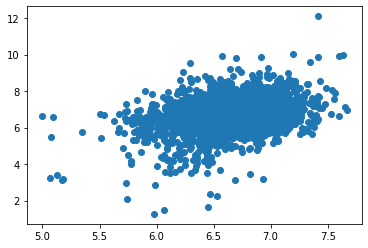

In [8]:
plt.scatter(df.sh7avg, df.sleep_hours);

In [9]:
from sklearn.cluster import DBSCAN
X_train = df[['sleep_hours','sh7avg']].dropna()
clustering = DBSCAN(eps=0.25, min_samples=5).fit(X_train)
DBSCAN_dataset = X_train.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_ 

DBSCAN_dataset.Cluster.value_counts().to_frame();

In [13]:
DBSCAN_dataset

,sleep_hours,sh7avg,Cluster
6,6.216667,6.968333,0
7,5.283333,7.068333,0
8,9.866667,6.918333,-1
9,5.966667,6.990000,0
10,7.400000,7.035000,0
...,...,...,...
2346,6.150000,6.738333,0
2347,7.433333,6.530000,0
2348,5.233333,6.375000,0
2349,7.933333,6.100833,0


In [10]:
notOutliers = DBSCAN_dataset[DBSCAN_dataset.Cluster != -1].index

X_train = df.iloc[notOutliers,[2,3,4]]
X_test = df.iloc[:,[2,3,4]]
Y = df.iloc[notOutliers,1]

X_train.shape, X_test.shape, Y.shape

((2307, 3), (2354, 3), (2307,))

In [11]:
Y

6       6.216667
7       5.283333
9       5.966667
10      7.400000
11      6.083333
          ...   
2346    6.150000
2347    7.433333
2348    5.233333
2349    7.933333
2350    3.850000
Name: sleep_hours, Length: 2307, dtype: float64

In [12]:
X_train

,Year,Month,Day
6,2015,2,25
7,2015,2,26
9,2015,2,28
10,2015,3,1
11,2015,3,2
...,...,...,...
2346,2021,12,22
2347,2021,12,23
2348,2021,12,24
2349,2021,12,25


In [21]:
df

,date,sleep_hours,Year,Month,Day,sh7avg
0,2015-02-19,6.400000,2015,2,19,NaN
1,2015-02-20,7.583333,2015,2,20,NaN
2,2015-02-21,6.350000,2015,2,21,NaN
3,2015-02-22,6.500000,2015,2,22,NaN
4,2015-02-23,8.916667,2015,2,23,NaN
...,...,...,...,...,...,...
2349,2021-12-25,7.933333,2021,12,25,6.100833
2350,2021-12-26,3.850000,2021,12,26,6.120000
2351,2021-12-29,6.175000,2021,12,29,NaN
2352,2021-12-30,5.158333,2021,12,30,NaN


In [22]:
df = pd.read_csv('trained_preprocessed.csv')
df

,sleep_hours,year,month,day,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,6.400000,2015,2,19,0,0,0,0,1,0,0
1,7.583333,2015,2,20,1,0,0,0,0,0,0
2,6.350000,2015,2,21,0,0,1,0,0,0,0
3,6.500000,2015,2,22,0,0,0,1,0,0,0
4,8.916667,2015,2,23,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2349,7.933333,2021,12,25,0,0,1,0,0,0,0
2350,3.850000,2021,12,26,0,0,0,1,0,0,0
2351,6.175000,2021,12,29,0,0,0,0,0,0,1
2352,5.158333,2021,12,30,0,0,0,0,1,0,0


In [23]:
test = pd.read_csv('test_preprocessed.csv')
test

,year,month,day,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,2022,1,1,0,0,1,0,0,0,0
1,2022,1,2,0,0,0,1,0,0,0
2,2022,1,3,0,1,0,0,0,0,0
3,2022,1,4,0,0,0,0,0,1,0
4,2022,1,5,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
414,2023,3,12,0,0,0,1,0,0,0
415,2023,3,13,0,1,0,0,0,0,0
416,2023,3,14,0,0,0,0,0,1,0
417,2023,3,15,0,0,0,0,0,0,1


In [25]:
X = df.drop('sleep_hours',axis=1)
y = df['sleep_hours']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
X_train

,year,month,day,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
1135,2018,7,31,0,0,0,0,0,1,0
37,2015,5,15,1,0,0,0,0,0,0
123,2015,10,2,1,0,0,0,0,0,0
2046,2021,2,19,1,0,0,0,0,0,0
394,2016,7,3,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1638,2019,12,30,0,1,0,0,0,0,0
1095,2018,6,21,0,0,0,0,1,0,0
1130,2018,7,26,0,0,0,0,1,0,0
1294,2019,1,15,0,0,0,0,0,1,0


In [28]:
automl = AutoML()
# Specify automl goal and constraint
automl_settings = {
    "time_budget": 300,  # in seconds
    "metric": 'rmse',
    "task": 'regression',
    "verbose":False
}

In [47]:
automl.fit(X_train,y_train,**automl_settings)

In [48]:
mean_squared_error(y_test,automl.predict(X_test))**0.5

1.0228728765692159

In [49]:
new_preds = automl.predict(test)

In [50]:
sub = pd.read_csv('sample_submission.csv')
sub

,date,sleep_hours
0,2022-01-01,1
1,2022-01-02,1
2,2022-01-03,1
3,2022-01-04,1
4,2022-01-05,1
...,...,...
414,2023-03-12,1
415,2023-03-13,1
416,2023-03-14,1
417,2023-03-15,1


In [51]:
sub['sleep_hours'] = new_preds

In [52]:
sub

,date,sleep_hours
0,2022-01-01,6.865500
1,2022-01-02,6.815297
2,2022-01-03,6.807569
3,2022-01-04,6.766370
4,2022-01-05,6.807569
...,...,...
414,2023-03-12,6.827694
415,2023-03-13,6.819966
416,2023-03-14,6.778766
417,2023-03-15,6.819966


<AxesSubplot:>

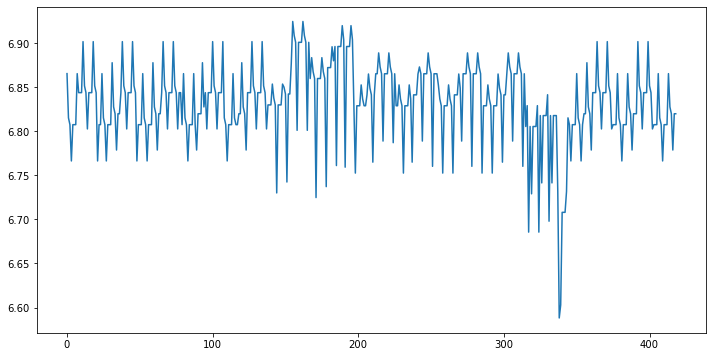

In [53]:
sub['sleep_hours'].plot(figsize=(12,6))

In [54]:
#sub.to_csv('automl_7.csv',index=False)

<AxesSubplot:>

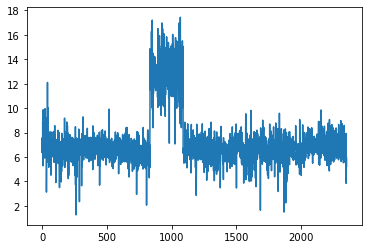

In [55]:
df['sleep_hours'].plot()

In [56]:
df.groupby('year').median()['sleep_hours']

year
2015    6.800000
2016    6.733333
2017    6.950000
2018    7.808333
2019    6.533333
2020    6.583333
2021    6.866667
Name: sleep_hours, dtype: float64

In [60]:
df[(df['sleep_hours'] < df['sleep_hours'].mean() + 1*df['sleep_hours'].std()) & (df['sleep_hours'] > df['sleep_hours'].mean() - 1*df['sleep_hours'].std()) ]

,sleep_hours,year,month,day,dow_Friday,dow_Monday,dow_Saturday,dow_Sunday,dow_Thursday,dow_Tuesday,dow_Wednesday
0,6.400000,2015,2,19,0,0,0,0,1,0,0
1,7.583333,2015,2,20,1,0,0,0,0,0,0
2,6.350000,2015,2,21,0,0,1,0,0,0,0
3,6.500000,2015,2,22,0,0,0,1,0,0,0
4,8.916667,2015,2,23,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2348,5.233333,2021,12,24,1,0,0,0,0,0,0
2349,7.933333,2021,12,25,0,0,1,0,0,0,0
2351,6.175000,2021,12,29,0,0,0,0,0,0,1
2352,5.158333,2021,12,30,0,0,0,0,1,0,0


<AxesSubplot:>

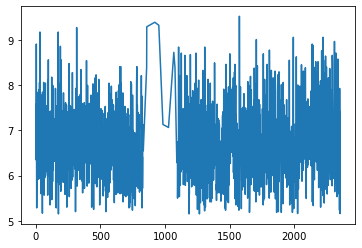

In [61]:
df[(df['sleep_hours'] < df['sleep_hours'].mean() + 1*df['sleep_hours'].std()) & (df['sleep_hours'] > df['sleep_hours'].mean() - 1*df['sleep_hours'].std())]['sleep_hours'].plot()